In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.special import erf
from colorplot import load_mags, color_cut, make_colorplot, plot_selection
from my_functions import *
from LumFunc_miniJPAS import LumFunc_hist, LumFunc
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [2]:
cat = load_noflag_cat('pkl/catalogDual_pz.pkl')
ftags = load_filter_tags()

### Probabilistic approach
Assuming gaussian error (valid up to SNR ~ 5):

$P(\mathrm{BB})=\mathcal{N}(\mathrm{BB},\,\sigma_\mathrm{BB}^2)\\
P(\mathrm{NB})=\mathcal{N}(\mathrm{NB},\,\sigma_\mathrm{NB}^2)$

Line excess: $\mathrm{BB} - \mathrm{NB}$, then

$P(\mathrm{BB}-\mathrm{NB})=\mathcal{N}(\mathrm{BB}-\mathrm{NB},\,\sigma_\mathrm{BB}^2+\sigma_\mathrm{NB}^2)$

The probability of an emission line is:

$P(\mathrm{line})=\int_{\mathrm{EW}_0=30\,\unicode{x212B}}^{\infty}\mathcal{N}(\mathrm{BB}-\mathrm{NB},\,\sigma_\mathrm{BB}^2+\sigma_\mathrm{NB}^2)
=\frac{1}{2}-\frac{1}{2}\cdot\mathrm{erf}\left(\frac{m_{\mathrm{EW}_0=30\,\unicode{x212B}}-(\mathrm{BB}-\mathrm{NB})}{\sqrt{2}(\sigma_\mathrm{BB}^2+\sigma_\mathrm{NB}^2)}\right)$

J0460


<ipython-input-3-e0bd96139e7a>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


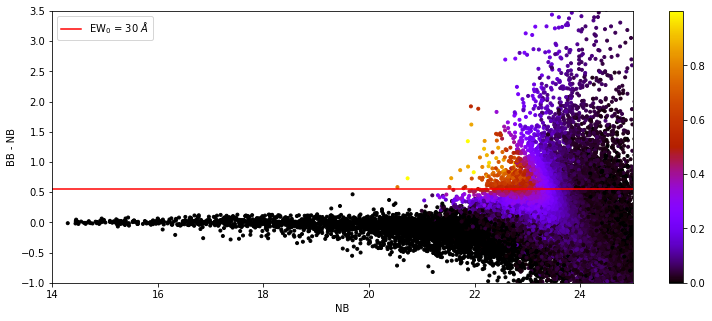

J0470


<ipython-input-3-e0bd96139e7a>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


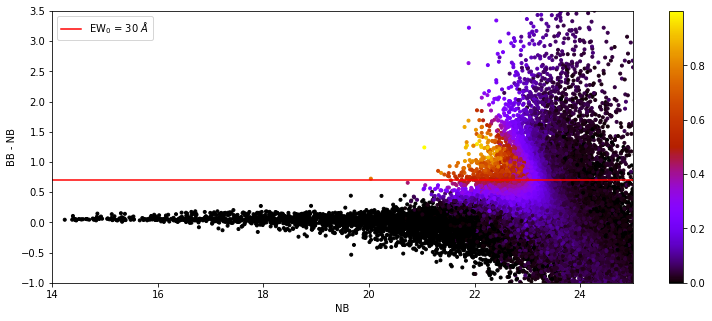

J0480


<ipython-input-3-e0bd96139e7a>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


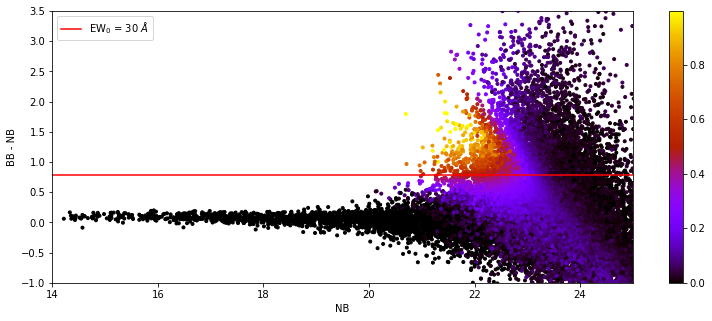

J0490


<ipython-input-3-e0bd96139e7a>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


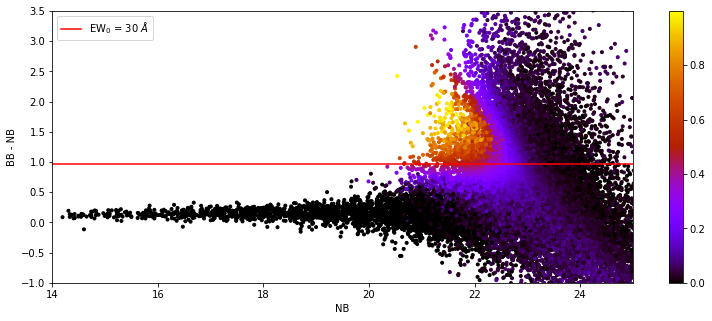

J0500


<ipython-input-3-e0bd96139e7a>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


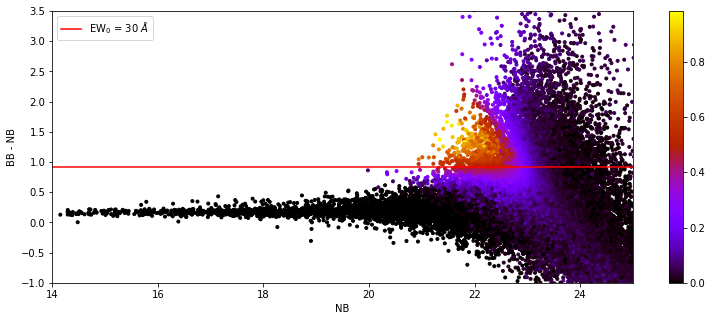

In [3]:
for nb_ind in [9, 10, 11, 12, 13]:
#     nb_ind = 8 # J0480
    print(ftags[nb_ind])
    bb_ind = -3
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)

    mu = bb_m - nb_m
    sigma = np.sqrt(bb_e**2 + nb_e**2)
    m_ew = color_cut(30, nb_ind) + np.nanmedian(mu)
    p_bbnb = 0.5 - 0.5*erf((m_ew - mu) / (np.sqrt(2)*sigma))
    p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
    p_nb = 0.5*erf((nbcut - nb_m) / (np.sqrt(2)*nb_e)) - 0.5*erf((0 - nb_m) / (np.sqrt(2)*nb_e))
    
    p_line_weights = p_bbnb * p_nb * p_bb

    make_colorplot(nb_m, bb_m, nb_e, bb_e, [], color_cut(30, nb_ind), p_line_weights)

J0460


<ipython-input-4-89a67e651d29>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


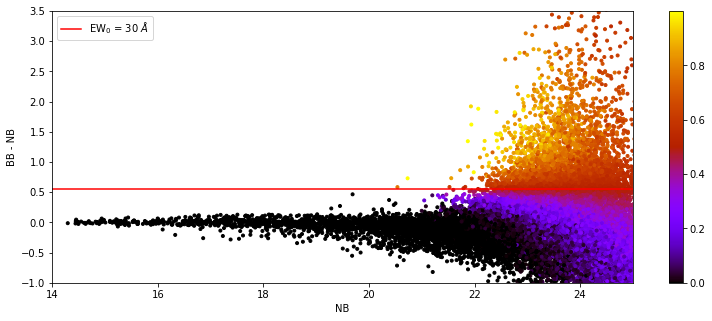

J0470


<ipython-input-4-89a67e651d29>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


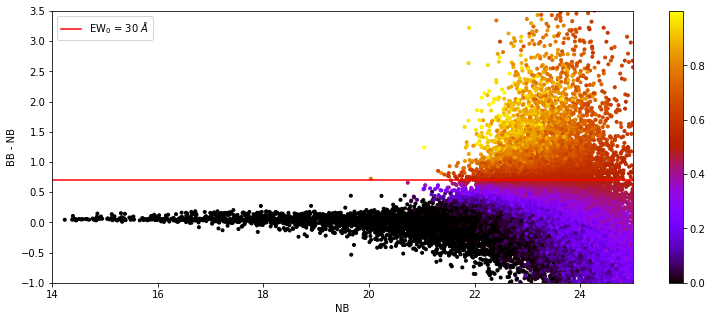

J0480


<ipython-input-4-89a67e651d29>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


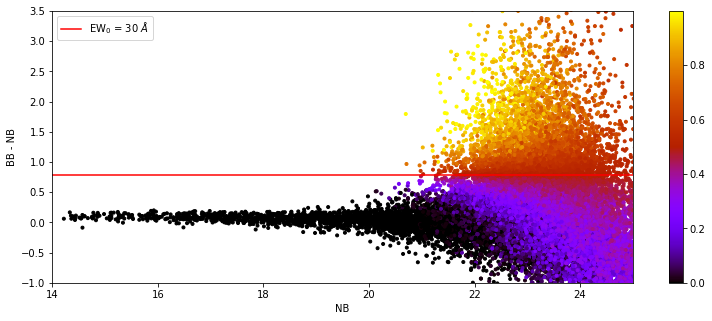

J0490


<ipython-input-4-89a67e651d29>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


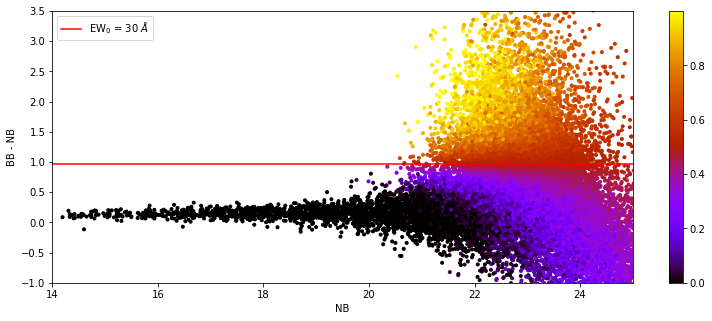

J0500


<ipython-input-4-89a67e651d29>:11: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


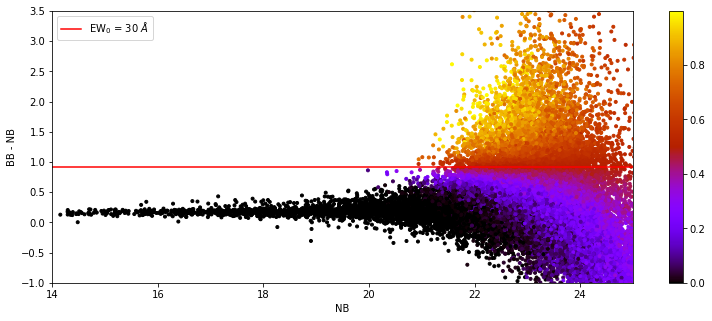

In [4]:
for nb_ind in [9, 10, 11, 12, 13]:
#     nb_ind = 8 # J0480
    print(ftags[nb_ind])
    bb_ind = -3
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)

    mu = bb_m - nb_m
    sigma = np.sqrt(bb_e**2 + nb_e**2)
    m_ew = color_cut(30, nb_ind) + np.nanmedian(mu)
    p_bbnb = 0.5 - 0.5*erf((m_ew - mu) / (np.sqrt(2)*sigma))
    p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
    p_nb = 0.5*erf((nbcut - nb_m) / (np.sqrt(2)*nb_e)) - 0.5*erf((0 - nb_m) / (np.sqrt(2)*nb_e))
    
    p_line_weights = p_bbnb * p_nb * p_bb

    make_colorplot(nb_m, bb_m, nb_e, bb_e, [], color_cut(30, nb_ind), p_bbnb)

In [5]:
def select_sources(nb_ind, bb_ind, min_score, mode = 1):
    bb_ind = -3
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)

    mu = bb_m - nb_m
    sigma = np.sqrt(bb_e**2 + nb_e**2)
    m_ew = color_cut(30, nb_ind) + np.nanmedian(mu)
    p_bbnb = 0.5 - 0.5*erf((m_ew - mu) / (np.sqrt(2)*sigma)) 
    p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
    p_nb = 0.5*erf((nbcut - nb_m) / (np.sqrt(2)*nb_e)) - 0.5*erf((0 - nb_m) / (np.sqrt(2)*nb_e))
        
    p_line = p_bbnb * p_bb * p_nb
    
    if mode == 1:
        selection, = np.where(
              (p_bbnb > erf(min_score/np.sqrt(2)))
            & (nb_m/nb_e > 5)
            & (bb_m/bb_e > 5)
        )
    if mode == 2:
        selection, = np.where(p_line > erf(min_score/np.sqrt(2))**3)
        
    return selection

J0460


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


3


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


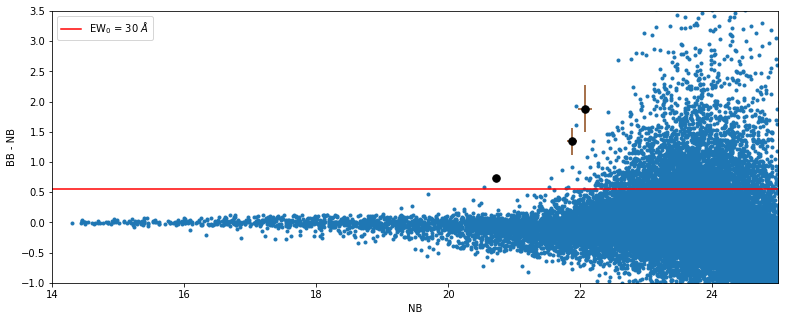

J0470


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


2


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


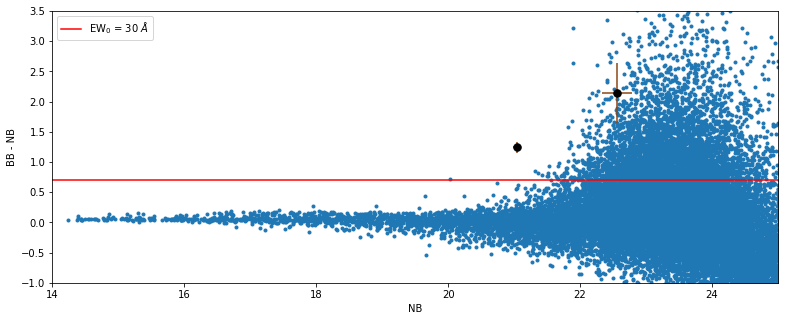

J0480


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


10


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


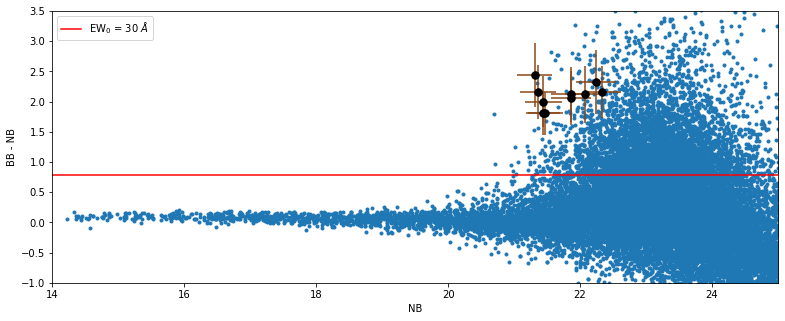

J0490


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


18


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


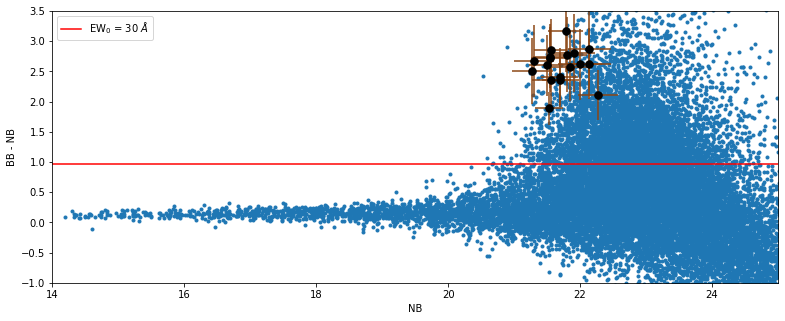

J0500


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


2


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


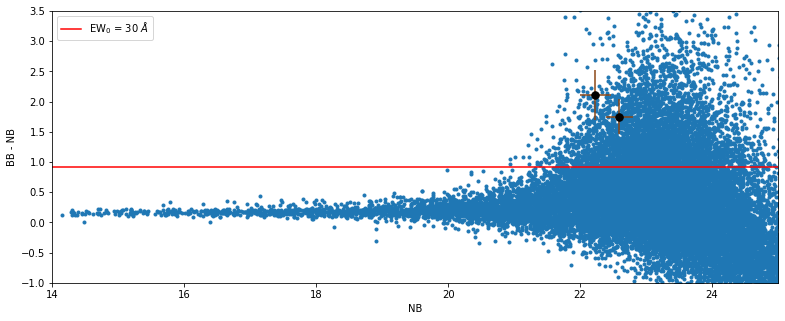

J0510


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


3


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


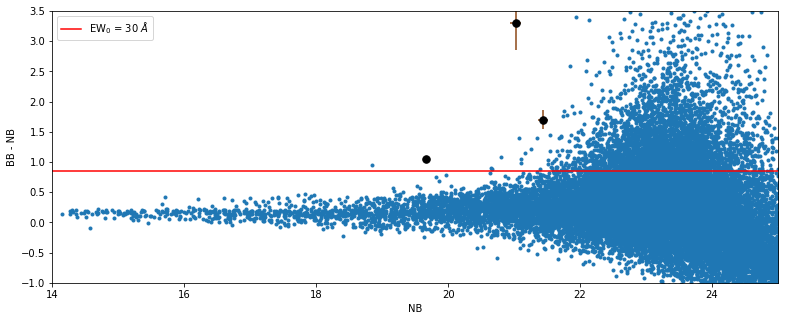

J0520


<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


4


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


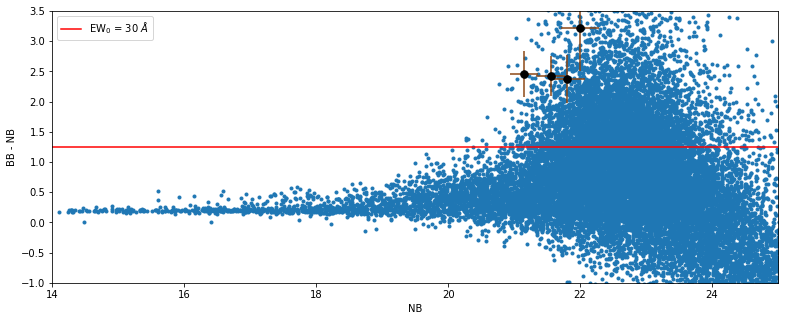

In [6]:
for nb_ind in [9, 10, 11, 12, 13, 14, 15]:
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)
    print(ftags[nb_ind])
    selection = select_sources(nb_ind, -3, 3)
    
    print(selection.shape[0])
    make_colorplot(nb_m, bb_m, nb_e, bb_e, selection, color_cut(30, nb_ind))

In [7]:
# filename = 'selected_sources/src'

# mask_fzero = (cat['MAG'][:,nb_ind] < 90) & (cat['MAG'][:,bb_ind] < 90)
# masked_mags = cat['MAG'][mask_fzero, :]
# masked_errs = cat['ERR'][mask_fzero, :]

# plot_selection(selection, nb_ind, filename, masked_mags, masked_errs)

## Cumulative LumFunc

In [8]:
## Load HETDEX LumFunc data (Zhang 2021)
filepath = 'csv/HETDEX_LumFunc.csv'
HETDEX_LF = []
with open(filepath, mode='r') as csvfile:
    rdlns = csv.reader(csvfile, delimiter=',')
    for line in rdlns:
        HETDEX_LF.append(line)
HETDEX_LF = np.array(HETDEX_LF).astype(float)

<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))
<ipython-input-5-949bcf243ce2>:18: RuntimeWarning: divide by zero encountered in true_divide
  & (bb_m/bb_e > 5)


[0, 0, 0, 2, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 2, 1, 2, 3, 2, 0, 0, 0]
[0, 0, 1, 2, 4, 8, 3, 0, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 0, 0, 2, 1, 0, 1, 0, 0]
[ 0  2  4  5  8 13  7  1  1  0]


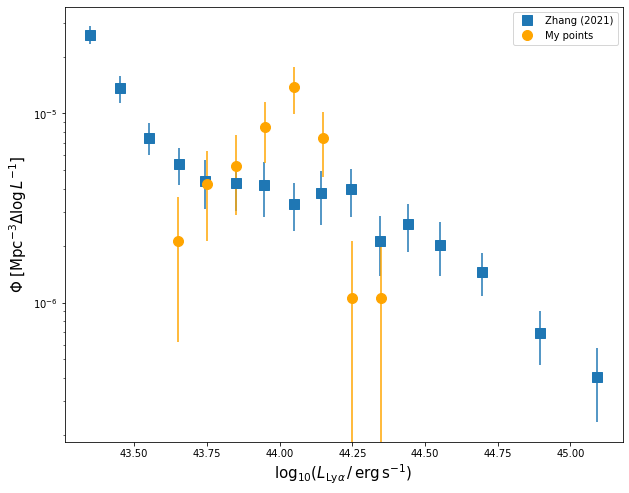

In [9]:
# LF selecting by BBNB excess and cutting SNR = 5

nb_ind_arr = [9,10,11,12,13,14,15]
hist_arr = []
volume_arr = []

for nb_ind in nb_ind_arr:
    bb_ind = -3
    selection = select_sources(nb_ind, bb_ind, 3)
    
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)
    
    w_pivot = central_wavelength(load_tcurves(load_filter_tags()))[nb_ind]
    w_pivot_bb = central_wavelength(load_tcurves(load_filter_tags()))[bb_ind]
    w_fwhm = nb_fwhm(load_tcurves(load_filter_tags()), nb_ind, True)
    f_line = mag_to_flux(nb_m[selection], w_pivot) - mag_to_flux(bb_m[selection], w_pivot_bb)
    n_bins = 10

    x, hist, volume, bin_width = LumFunc_hist(f_line, w_pivot, w_fwhm, n_bins, 43.5, 44.5)
    hist_arr.append(hist)
    volume_arr.append(volume)
    
y = np.sum(hist_arr, axis = 0)/np.sum(volume_arr)/bin_width
errors = np.sqrt(np.sum(hist_arr, axis = 0))/np.sum(volume_arr)/bin_width
print(np.sum(hist_arr, axis = 0))

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(HETDEX_LF[:,0], HETDEX_LF[:,1], 's', markersize = 10, label = 'Zhang (2021)')
ax.errorbar(HETDEX_LF[:,0], HETDEX_LF[:,1], yerr = HETDEX_LF[:,2] - HETDEX_LF[:,1], fmt = 'none')

ax.plot(x, y, '.', markersize=20, c='orange', label = 'My points')
ax.errorbar(x, y, yerr = errors, fmt = 'none', c='orange')

ax.set_yscale('log')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\Delta\log L^{-1}$]', size=15)
ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}\,/\,\mathrm{erg}\,\mathrm{s}^{-1})$', size=15)
ax.legend()
plt.show()

<ipython-input-5-949bcf243ce2>:9: RuntimeWarning: divide by zero encountered in true_divide
  p_bb = 0.5*erf((bbcut - bb_m) / (np.sqrt(2)*bb_e)) - 0.5*erf((0 - bb_m) / (np.sqrt(2)*bb_e))


[0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 2, 3, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0 0 0 1 2 5 2 1 1 1]


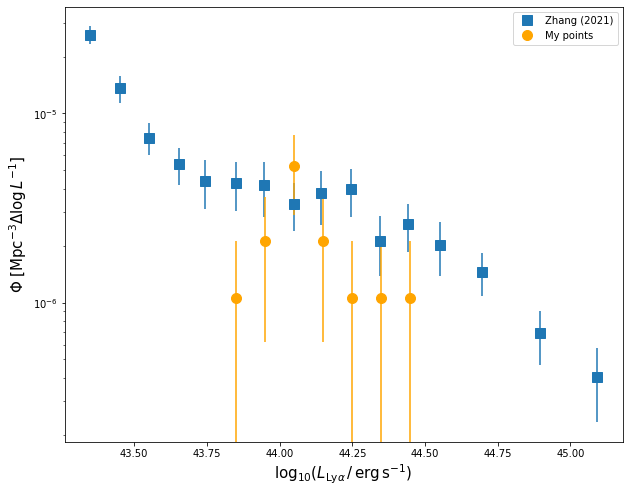

In [10]:
# LF selecting by product of probabilities

nb_ind_arr = [9,10,11,12,13,14,15]
hist_arr = []
volume_arr = []

for nb_ind in nb_ind_arr:
    bb_ind = -3
    selection = select_sources(nb_ind, bb_ind, 3, 2)
    
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)
    
    w_pivot = central_wavelength(load_tcurves(load_filter_tags()))[nb_ind]
    w_pivot_bb = central_wavelength(load_tcurves(load_filter_tags()))[bb_ind]
    w_fwhm = nb_fwhm(load_tcurves(load_filter_tags()), nb_ind, True)
    f_line = mag_to_flux(nb_m[selection], w_pivot) - mag_to_flux(bb_m[selection], w_pivot_bb)
    n_bins = 10

    x, hist, volume, bin_width = LumFunc_hist(f_line, w_pivot, w_fwhm, n_bins, 43.5, 44.5)
    hist_arr.append(hist)
    volume_arr.append(volume)
    
y = np.sum(hist_arr, axis = 0)/np.sum(volume_arr)/bin_width
errors = np.sqrt(np.sum(hist_arr, axis = 0))/np.sum(volume_arr)/bin_width
print(np.sum(hist_arr, axis = 0))

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(HETDEX_LF[:,0], HETDEX_LF[:,1], 's', markersize = 10, label = 'Zhang (2021)')
ax.errorbar(HETDEX_LF[:,0], HETDEX_LF[:,1], yerr = HETDEX_LF[:,2] - HETDEX_LF[:,1], fmt = 'none')

ax.plot(x, y, '.', markersize=20, c='orange', label = 'My points')
ax.errorbar(x, y, yerr = errors, fmt = 'none', c='orange')

ax.set_yscale('log')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\Delta\log L^{-1}$]', size=15)
ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}\,/\,\mathrm{erg}\,\mathrm{s}^{-1})$', size=15)
ax.legend()
plt.show()

/home/alberto/cosmos/LAEs/LumFunc_miniJPAS.py:46: RuntimeWarning: invalid value encountered in log10
  L_line = np.log10(L_line)


[14.557226888310113, 9.192478365005636, 5.113965009327663, 5.409499470445875, 3.1639868593352265, 2.6536356894538478, 2.705838162793897, 3.1311545200703175, 2.159811557305851, 2.3103048347203337]
[40.92912020139159, 23.213711838657417, 11.756247695128906, 6.065920843663394, 5.512973431555571, 3.875451288525985, 4.77419426095509, 3.2479541846085116, 4.540998927502962, 1.5813663930852893]
[58.13401956562852, 36.11020842848181, 24.690735063909905, 12.757387311794215, 8.792084686019384, 5.404121618593798, 4.982224866488223, 3.849423663640377, 3.4861440142910434, 2.6956215211090524]
[108.48061607213539, 77.17187877964861, 62.68846563880255, 44.52564430851929, 40.24649933252113, 21.802414315933817, 7.474652807826019, 9.504280006017485, 6.067030632340265, 6.536765609148449]
[78.0409081119784, 56.24386123703824, 40.895159355683916, 30.930564548050718, 17.902156361976765, 10.779479563727, 8.523419406291973, 6.493491176967186, 4.5194392050958925, 2.372384465173311]
[45.20862772923174, 33.1947206

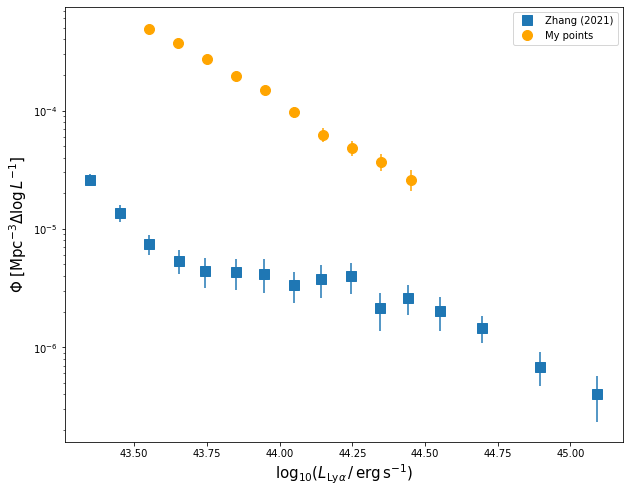

In [11]:
# Weighted LF

nb_ind_arr = [9,10,11,12,13,14,15]
hist_arr = []
volume_arr = []

for nb_ind in nb_ind_arr:
    bb_ind = -3
    
    nb_m, bb_m, nb_e, bb_e, bbcut, nbcut = load_mags(nb_ind, bb_ind)
    
    w_pivot = central_wavelength(load_tcurves(load_filter_tags()))[nb_ind]
    w_pivot_bb = central_wavelength(load_tcurves(load_filter_tags()))[bb_ind]
    w_fwhm = nb_fwhm(load_tcurves(load_filter_tags()), nb_ind, True)
    f_line = mag_to_flux(nb_m, w_pivot) - mag_to_flux(bb_m, w_pivot_bb)
    n_bins = 10

    x, hist, volume, bin_width =\
        LumFunc_hist(
        f_line, w_pivot, w_fwhm, n_bins, 43.5, 44.5, p_line_weights
    )
    hist_arr.append(hist)
    volume_arr.append(volume)
    
y = np.sum(hist_arr, axis = 0)/np.sum(volume_arr)/bin_width
errors = np.sqrt(np.sum(hist_arr, axis = 0))/np.sum(volume_arr)/bin_width
print(np.sum(hist_arr, axis = 0))

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(HETDEX_LF[:,0], HETDEX_LF[:,1], 's', markersize = 10, label = 'Zhang (2021)')
ax.errorbar(HETDEX_LF[:,0], HETDEX_LF[:,1], yerr = HETDEX_LF[:,2] - HETDEX_LF[:,1], fmt = 'none')

ax.plot(x, y, '.', markersize=20, c='orange', label = 'My points')
ax.errorbar(x, y, yerr = errors, fmt = 'none', c='orange')

ax.set_yscale('log')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\Delta\log L^{-1}$]', size=15)
ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}\,/\,\mathrm{erg}\,\mathrm{s}^{-1})$', size=15)
ax.legend()
plt.show()

In [12]:
errors = np.load('npy/errors5Sigma.npy')
w_central = central_wavelength(load_tcurves(load_filter_tags()))

min_g = errors[bb_ind,1]*5
z_arr = np.array(w_central)[nb_ind_arr]/1215.67 - 1
ew_arr = 30 * (z_arr + 1)
r_arr = cosmo.luminosity_distance(z_arr).to(u.cm).value

L_min_arr = (ew_arr * min_g) * 4*np.pi * r_arr**2
print(np.log10(L_min_arr))

[42.96246282 43.00062296 43.04058155 43.07748003 43.11370659 43.14810892
 43.18507148]
